In [1]:
import numpy
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/train_dst_new.csv')
data.index = data['index']
data.drop(columns=['index'], inplace=True)
data

,Bz_GSE,Sigma_Bz_GSE,Proton_density,Plasma_speed,Dst_index
index,,,,,
1963-12-27 22:00:00,-0.001974,0.043920,0.139963,0.213980,0.024615
1963-12-27 23:00:00,-0.006086,0.045191,0.137727,0.220578,0.024615
1963-12-28 00:00:00,-0.010197,0.046461,0.135492,0.227177,0.027692
1963-12-28 01:00:00,-0.014309,0.047731,0.133256,0.233775,0.015385
1963-12-28 02:00:00,-0.018421,0.049002,0.131020,0.240373,0.012308
...,...,...,...,...,...
1988-05-10 08:00:00,-0.025000,0.036782,0.045879,0.504407,-0.083077
1988-05-10 09:00:00,-0.035417,0.031418,0.045313,0.512569,-0.070769
1988-05-10 10:00:00,-0.045833,0.026054,0.044747,0.520731,-0.070769


In [3]:
Bz = data['Bz_GSE']
Sigma_Bz = data['Sigma_Bz_GSE']
n = data['Proton_density']
v = data['Plasma_speed']
Dst = data['Dst_index']

# Basic PPS Function

In [13]:
def nRMSE(o, s):
    MSE = np.square(np.subtract(o, s)).mean()
    return math.sqrt(MSE) / np.std(o)


def pps(x, y):
    x_train, x_test = train_test_split(x, test_size=0.4)
    y_train, y_test = train_test_split(y, test_size=0.4)

    # Cross-validating decision tree regressor
    # with train data and choosing best model
    # parameters = {
    #     'max_depth': range(1, 20)
    # }
    # clf = GridSearchCV(DecisionTreeRegressor(), parameters, n_jobs=1)
    # clf.fit(X=x.to_numpy().reshape(-1, 1), y=y)
    # tree = clf.best_estimator_
    tree = DecisionTreeRegressor()
    tree.fit(x.to_numpy().reshape(-1, 1), y)

    # scores = cross_val_score(
    #     DecisionTreeRegressor(),
    #     x.to_numpy().reshape(-1, 1), y,
    #     cv=7, scoring='neg_mean_absolute_error'
    # )
    # y_predict = scores.mean()

    # predicting with test values
    y_predict = tree.predict(x.to_numpy().reshape(-1, 1))


    # Create predictions from persistance model.
    # Persistance model always assumes that the next value to predict is the same as it is now
    # y_(t+1) = y_t
    y_naive = x.shift(1)
    y_naive = y_naive.fillna(0)

    # Create a dummy regressor with different strategies of naively predicting next hour of data
    # with scikits learn dummyRegresor
    # strategies = maean, median, quantile, constant
    dummy = DummyRegressor(strategy='quantile', quantile=0.5)
    dummy.fit(x, y)
    #y_naive = dummy.predict(x)

    # calculating normalised RMSE for predicted values and naive values
    nRMSE_model = nRMSE(y, y_predict)
    nRMSE_naive = nRMSE(y, y_naive)
    MAE_model = mean_absolute_error(y, y_predict)
    MAE_naive = mean_absolute_error(y, y_naive)

    # print(MAE_model, MAE_naive)
    # print(nRMSE_model, nRMSE_naive)

    # if MAE_model > MAE_naive:
    #     return 0
    # else:
    #     return 1 - (MAE_model / MAE_naive)

    print(nRMSE_model / nRMSE_naive)

    return [1 - (nRMSE_model / nRMSE_naive), tree]



# Random forest PPS calculation

In [19]:
from sklearn.ensemble import RandomForestRegressor

def pps_random_forest(data, predictor, target):
    if not data.columns[0] == data.columns[1]:
        x_for_naive = data[predictor]
        y_for_naive = data[target]

        """
        Random forest model
        """
        data = data.fillna(method='ffill')
    
        print(data.columns)
        for lag in range(1, 25):  # 1 to 24 hours lag
            data[f'lag_{lag}'] = data[target].shift(lag)
    
        data.dropna(inplace=True)
    
        X = data.drop(target, axis=1)  # replace with your target column
        y = data[target]
        
        X_train, X_test = train_test_split(X, test_size=0.2, random_state=42, shuffle=False)
        y_train, y_test = train_test_split(y, test_size=0.2, random_state=42, shuffle=False)
    
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        
        y_pred = rf_model.predict(X_test)
    
        """
        Persistance model
        """
        y_naive = X.shift(1)
        y_naive = y_naive.fillna(0)

        naive_nRMSEs = []
        for col in X.columns:
            naive_nRMSEs.append(nRMSE(y, X[col]))

        nRMSE_naive = np.mean(np.array(naive_nRMSEs))
        
        """
        Quantile model (median = 0.5, maximum = 1, minimum = 0)
        """
        # dummy = DummyRegressor(strategy='quantile', quantile=0.5)
        # dummy.fit(X_train, y_train)
        # y_naive = dummy.predict(X_test)
        
        
        nRMSE_model = nRMSE(y_test, y_pred)
        # nRMSE_naive = nRMSE(y_test, y_naive)
        
        return 1 - (nRMSE_model / nRMSE_naive)
        # return y_naive
    else:
        return 1

# pps_random_forest(data.copy()[['Bz_GSE', 'Sigma_Bz_GSE']], 'Sigma_Bz_GSE', 'Bz_GSE')


## Random Forest PPS Matrix Calculation

In [13]:
def random_forest_matrix_calculation(data):
    pps_matrix = []
    for icname, icdata in data.items():
        pps_row = []
        for jcname, jcdata in data.items():
            #print(f'Now caluclating: {icname},{jcname}')
            pps_row.append(pps_random_forest(data.copy()[[icname, jcname]], icname, jcname))
        pps_matrix.append(pps_row)
    
    pd_mat = pd.DataFrame(pps_matrix, columns=['Bz', 'Sigma_Bz', 'n', 'v', 'DST'])
    pd_mat.index = ['Bz', 'Sigma_Bz', 'n', 'v', 'DST']
    
    
    htmap = sn.heatmap(pd_mat, annot=True, cmap='Blues')
    htmap.set(title='Naive Model Persistance')
    plt.xlabel('Predictor')
    plt.ylabel('Target')
    fig = htmap.get_figure()
    fig.savefig('./data/PPS_naivePersistance_RandomForest.png') 

random_forest_matrix_calculation(data)

Index(['Bz_GSE', 'Sigma_Bz_GSE'], dtype='object')
Index(['Bz_GSE', 'Proton_density'], dtype='object')
Index(['Bz_GSE', 'Plasma_speed'], dtype='object')
Index(['Bz_GSE', 'Dst_index'], dtype='object')
Index(['Sigma_Bz_GSE', 'Bz_GSE'], dtype='object')
Index(['Sigma_Bz_GSE', 'Proton_density'], dtype='object')
Index(['Sigma_Bz_GSE', 'Plasma_speed'], dtype='object')
Index(['Sigma_Bz_GSE', 'Dst_index'], dtype='object')
Index(['Proton_density', 'Bz_GSE'], dtype='object')
Index(['Proton_density', 'Sigma_Bz_GSE'], dtype='object')
Index(['Proton_density', 'Plasma_speed'], dtype='object')
Index(['Proton_density', 'Dst_index'], dtype='object')
Index(['Plasma_speed', 'Bz_GSE'], dtype='object')
Index(['Plasma_speed', 'Sigma_Bz_GSE'], dtype='object')
Index(['Plasma_speed', 'Proton_density'], dtype='object')
Index(['Plasma_speed', 'Dst_index'], dtype='object')
Index(['Dst_index', 'Bz_GSE'], dtype='object')
Index(['Dst_index', 'Sigma_Bz_GSE'], dtype='object')
Index(['Dst_index', 'Proton_density'], dtype

# Matrix Calculation

In [7]:
def matrix(data):
    
    pps_matrix = []

    for icname, icdata in data.items():
        pps_row = []
        for jcname, jcdata in data.items():
            # print(f'Now caluclating: {icname},{jcname}')
            pps_row.append(pps(icdata, jcdata)[0])
        pps_matrix.append(pps_row)
    
   

    pd_mat = pd.DataFrame(pps_matrix, columns=['Bz', 'Sigma_Bz', 'n', 'v', 'DST'])
    pd_mat.index = ['Bz', 'Sigma_Bz', 'n', 'v', 'DST']

    
    htmap = sn.heatmap(pd_mat, annot=True, cmap='Blues')
    htmap.set(title='naive model persistance')
    plt.xlabel('Predictor')
    plt.ylabel('Target')
    fig = htmap.get_figure()
    fig.savefig('./data/PPS_naivePersistance.png')  
    # plt.savefig("./outputs/pps_result.png")
    # return pd_mat

4.907382937656548e-16
0.30887074922593305
0.30009346066339
0.20940034596017473
0.5217017789117313
0.7978068592992998
2.882248479046487e-15
0.7288108809422582
0.24244357758939983
0.47456901075658015
0.767844575155422
0.7137925057513665
1.6891311598427505e-15
0.2282499474505152
0.48255011703045175
0.23708820290809135
0.11170344541978582
0.10834530696572786
5.622482112288155e-15
0.13770882002743223
0.6687941713234343
0.24353074139785041
0.2323341100593178
0.1675877243677593
4.914083942057799e-15


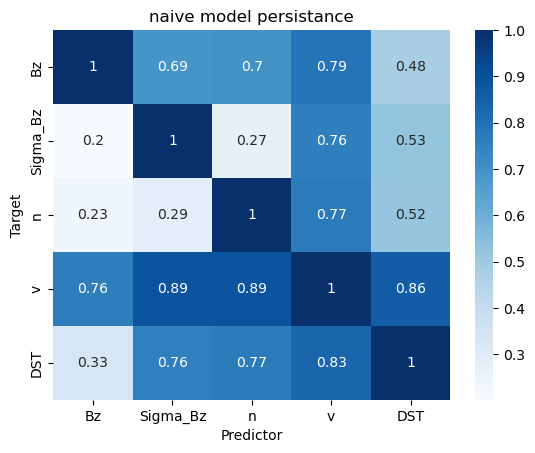

In [8]:
matrix(data)

In [9]:
%matplotlib qt
pd.concat([Bz, Sigma_Bz], axis=1).plot()

<Axes: xlabel='index'>

# Process NM data for PPS analysis

In [3]:
NMdata = pd.read_csv('./data/LMKS_NM_1981-2023_hour.csv')
NMdata.index = NMdata['Unnamed: 0']
NMdata.drop(columns='Unnamed: 0', inplace=True)
NMdata = 2 * (NMdata - NMdata.min()) / (NMdata.max() - NMdata.min()) - 1
NMdata

,H_COR
Unnamed: 0,
1981-12-01 00:00:00,-0.659395
1981-12-01 01:00:00,-0.663675
1981-12-01 02:00:00,-0.664384
1981-12-01 03:00:00,-0.670094
1981-12-01 04:00:00,-0.668663
...,...
2023-07-10 19:00:00,-0.595307
2023-07-10 20:00:00,-0.595307
2023-07-10 21:00:00,-0.595307


<Axes: xlabel='Unnamed: 0'>

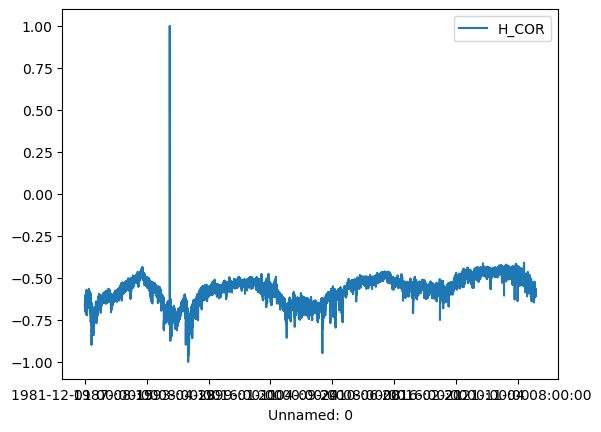

In [4]:
NMdata.plot()

In [5]:
NMdata_reindexed = NMdata.reindex(data.index)
NMdata_reindexed.dropna(inplace=True)
NMdata_reindexed

,H_COR
index,
1982-01-30 23:00:00,-0.626602
1982-01-31 00:00:00,-0.635161
1982-01-31 01:00:00,-0.640150
1982-01-31 02:00:00,-0.642999
1982-01-31 03:00:00,-0.650127
...,...
1988-05-10 08:00:00,-0.551500
1988-05-10 09:00:00,-0.551139
1988-05-10 10:00:00,-0.547109


In [6]:
NMdata_reindexed.shape

(2352, 1)

In [7]:
NMdata_reindexed.index = pd.to_datetime(NMdata_reindexed.index)
data.index = pd.to_datetime(data.index)
data_reindexed = data[data.index.year > 1981]

In [9]:
all_data_reindexed = pd.concat([data_reindexed, NMdata_reindexed], axis=1)
all_data_reindexed

,Bz_GSE,Sigma_Bz_GSE,Proton_density,Plasma_speed,Dst_index,H_COR
index,,,,,,
1982-01-30 23:00:00,0.031250,0.062069,0.016143,0.595495,-0.067692,-0.626602
1982-01-31 00:00:00,0.040625,0.051724,0.017842,0.569050,-0.064615,-0.635161
1982-01-31 01:00:00,-0.184375,0.093103,0.049278,0.594515,-0.024615,-0.640150
1982-01-31 02:00:00,-0.153125,0.089655,0.053526,0.577865,-0.018462,-0.642999
1982-01-31 03:00:00,-0.096875,0.075862,0.074766,0.573947,-0.018462,-0.650127
...,...,...,...,...,...,...
1988-05-10 08:00:00,-0.025000,0.036782,0.045879,0.504407,-0.083077,-0.551500
1988-05-10 09:00:00,-0.035417,0.031418,0.045313,0.512569,-0.070769,-0.551139
1988-05-10 10:00:00,-0.045833,0.026054,0.044747,0.520731,-0.070769,-0.547109


# Caculating PPS, random forest, with pps data

Index(['Bz_GSE', 'Sigma_Bz_GSE'], dtype='object')
Index(['Bz_GSE', 'Proton_density'], dtype='object')
Index(['Bz_GSE', 'Plasma_speed'], dtype='object')
Index(['Bz_GSE', 'Dst_index'], dtype='object')
Index(['Bz_GSE', 'H_COR'], dtype='object')
Index(['Sigma_Bz_GSE', 'Bz_GSE'], dtype='object')
Index(['Sigma_Bz_GSE', 'Proton_density'], dtype='object')
Index(['Sigma_Bz_GSE', 'Plasma_speed'], dtype='object')
Index(['Sigma_Bz_GSE', 'Dst_index'], dtype='object')
Index(['Sigma_Bz_GSE', 'H_COR'], dtype='object')
Index(['Proton_density', 'Bz_GSE'], dtype='object')
Index(['Proton_density', 'Sigma_Bz_GSE'], dtype='object')
Index(['Proton_density', 'Plasma_speed'], dtype='object')
Index(['Proton_density', 'Dst_index'], dtype='object')
Index(['Proton_density', 'H_COR'], dtype='object')
Index(['Plasma_speed', 'Bz_GSE'], dtype='object')
Index(['Plasma_speed', 'Sigma_Bz_GSE'], dtype='object')
Index(['Plasma_speed', 'Proton_density'], dtype='object')
Index(['Plasma_speed', 'Dst_index'], dtype='object')
I

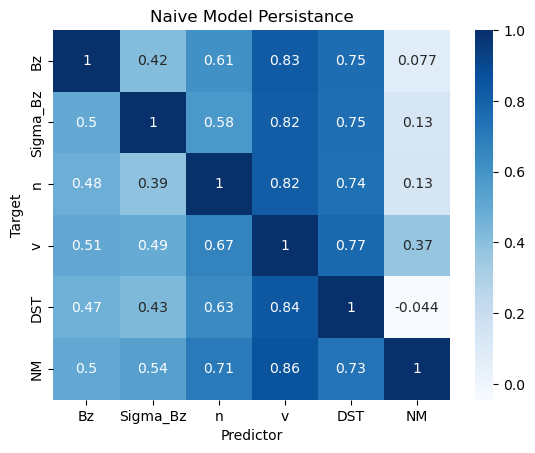

In [20]:
pps_matrix = []
for icname, icdata in all_data_reindexed.items():
    pps_row = []
    for jcname, jcdata in all_data_reindexed.items():
        #print(f'Now caluclating: {icname},{jcname}')
        pps_row.append(pps_random_forest(all_data_reindexed.copy()[[icname, jcname]], icname, jcname))
    pps_matrix.append(pps_row)

pd_mat = pd.DataFrame(pps_matrix, columns=['Bz', 'Sigma_Bz', 'n', 'v', 'DST', 'NM'])
pd_mat.index = ['Bz', 'Sigma_Bz', 'n', 'v', 'DST', 'NM']


htmap = sn.heatmap(pd_mat, annot=True, cmap='Blues')
htmap.set(title='Naive Model Persistance')
plt.xlabel('Predictor')
plt.ylabel('Target')
fig = htmap.get_figure()
fig.savefig('./data/PPS_wNM_naivePersistance_RandomForest.png') 

In [17]:
all_data_reindexed

,Bz_GSE,Sigma_Bz_GSE,Proton_density,Plasma_speed,Dst_index,H_COR
index,,,,,,
1982-01-30 23:00:00,0.031250,0.062069,0.016143,0.595495,-0.067692,-0.626602
1982-01-31 00:00:00,0.040625,0.051724,0.017842,0.569050,-0.064615,-0.635161
1982-01-31 01:00:00,-0.184375,0.093103,0.049278,0.594515,-0.024615,-0.640150
1982-01-31 02:00:00,-0.153125,0.089655,0.053526,0.577865,-0.018462,-0.642999
1982-01-31 03:00:00,-0.096875,0.075862,0.074766,0.573947,-0.018462,-0.650127
...,...,...,...,...,...,...
1988-05-10 08:00:00,-0.025000,0.036782,0.045879,0.504407,-0.083077,-0.551500
1988-05-10 09:00:00,-0.035417,0.031418,0.045313,0.512569,-0.070769,-0.551139
1988-05-10 10:00:00,-0.045833,0.026054,0.044747,0.520731,-0.070769,-0.547109
